# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.2


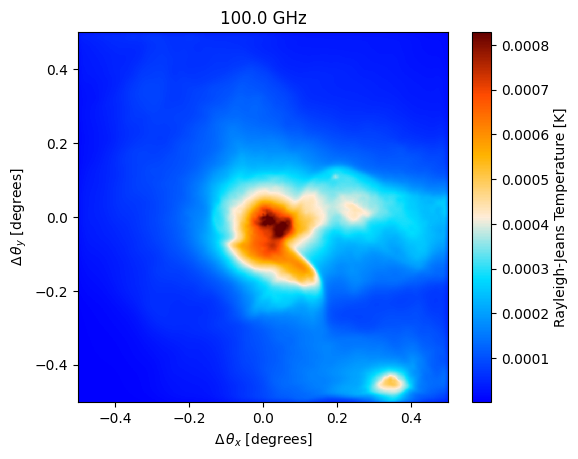

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/big_cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename,
                                width=1., #degrees
                                index=1,
                                center=(300.0, -10.0), #RA and Dec in degrees
                                units ='Jy/pixel'
                               )

input_map.to(units="K_RJ").plot()

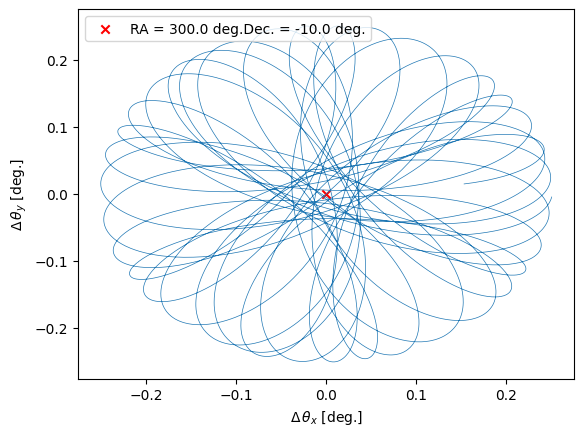

In [2]:
plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                      duration=60, # in seconds
                      sample_rate=225, # in Hz
                        # sample_rate=20, # in Hz
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")
plan.plot()

2024-10-10 15:58:18.307 INFO: Constructed instrument.
2024-10-10 15:58:18.307 INFO: Constructed plan.
2024-10-10 15:58:18.308 INFO: Constructed site.
2024-10-10 15:58:18.854 INFO: Constructed boresight.
2024-10-10 15:58:27.307 INFO: Constructed offsets.


Initialized base in 9001 ms.


Generating noise: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]
Generating atmosphere: 4it [00:08,  2.18s/it]
Sampling map (f092): 100%|██████████| 1/1 [02:07<00:00, 127.25s/it]


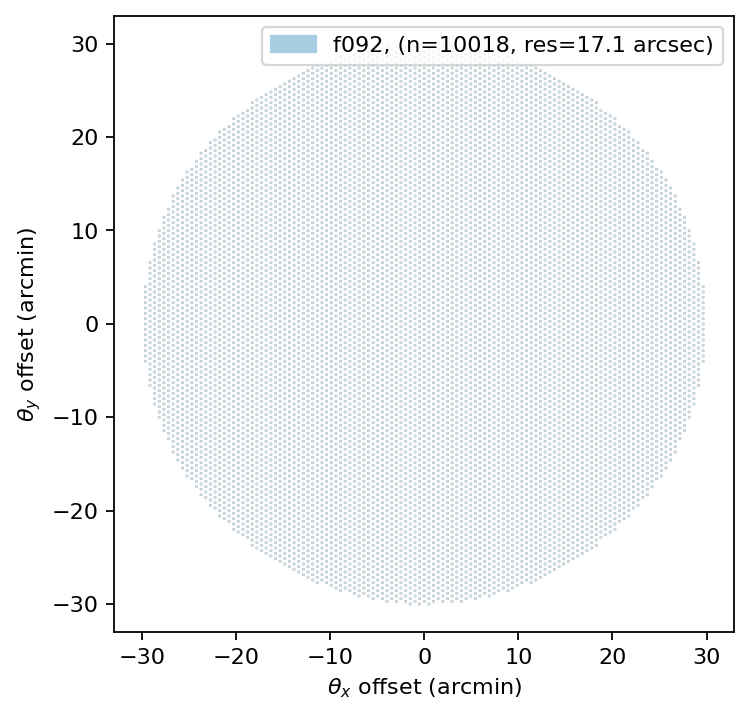

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.get_atlast()
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
import scipy as sp

jax_tods_atmos = tod_truthmap.components['atmosphere']
jax_tods_atmos_smooth = np.zeros(jax_tods_atmos.shape)

for i in range(jax_tods_atmos.shape[0]):
    jax_tods_atmos_smooth[i] = sp.ndimage.gaussian_filter1d(jax_tods_atmos[i], sigma=50)

In [5]:
jax_tods_atmos_smooth.shape

(10018, 13500)

In [6]:
from skimage.transform import resize
# for i in range(jax_tods_atmos_smooth.shape[0]):
rescale = jax_tods_atmos_smooth.shape[1]//2

truth_rescaled = np.zeros((jax_tods_atmos_smooth.shape[0], rescale))
truth_rerescaled = np.zeros((jax_tods_atmos_smooth.shape[0], jax_tods_atmos_smooth.shape[1]))

# for i in [0]:
for i in range(jax_tods_atmos_smooth.shape[0]):
    truth_rescaled[i] = resize(jax_tods_atmos_smooth[i], (rescale,), anti_aliasing=True)
    truth_rerescaled[i] = resize(truth_rescaled[i], (jax_tods_atmos_smooth.shape[1],), anti_aliasing=True)

truth_rescaled

array([[20.51499547, 20.51499271, 20.51498784, ..., 20.5396846 ,
        20.53965885, 20.53964571],
       [20.51588525, 20.51588324, 20.51587677, ..., 20.54057438,
        20.54054778, 20.54053549],
       [20.5158862 , 20.51588345, 20.51587857, ..., 20.54057353,
        20.54054778, 20.54053549],
       ...,
       [20.55812444, 20.55812168, 20.55811681, ..., 20.58273833,
        20.58271248, 20.58269933],
       [20.55806722, 20.55806446, 20.55805959, ..., 20.58274501,
        20.58271926, 20.58270696],
       [20.60845651, 20.6084545 , 20.60844803, ..., 20.63307326,
        20.63304741, 20.63303426]])

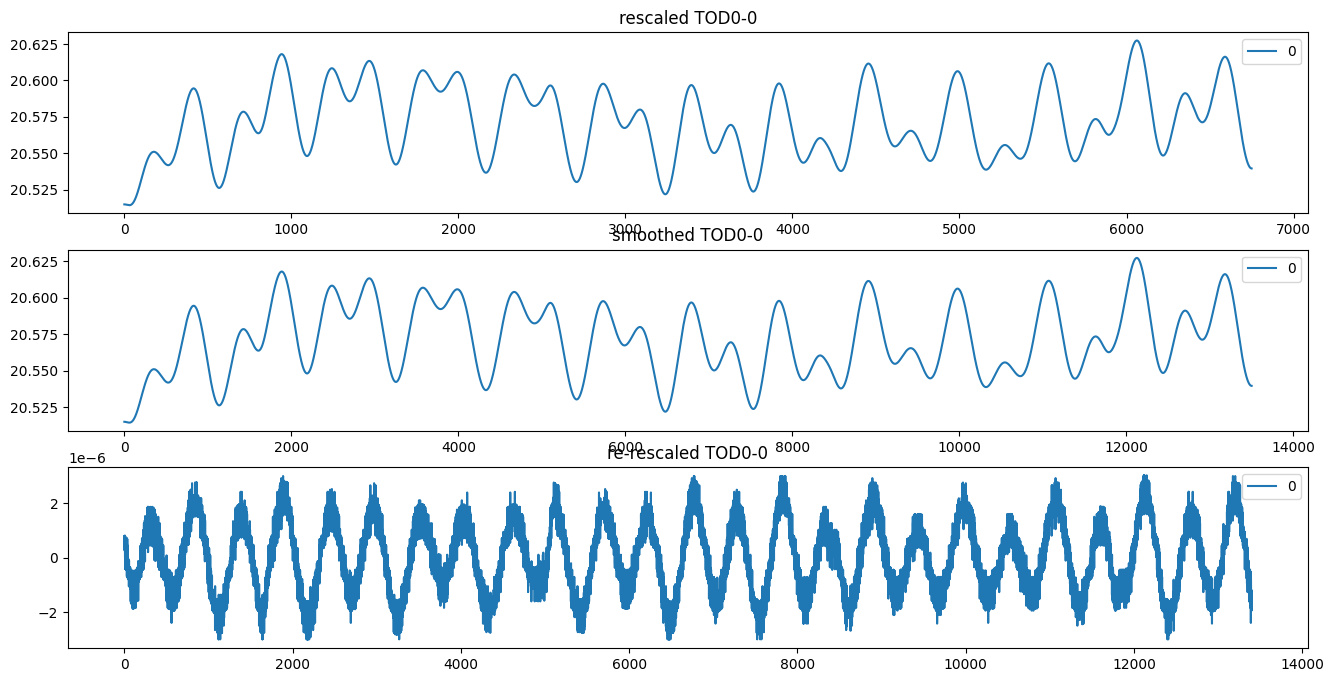

In [7]:
# plot smoothed atmos:

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in [0, 10, 100, 200]:
for i in [0]:
    im0 = axes[0].plot(truth_rescaled[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i], label=i)
    im2 = axes[2].plot((jax_tods_atmos_smooth[i] - truth_rerescaled[i])[:-100], label=i)
    
axes[0].title.set_text(f'rescaled TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'smoothed TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f're-rescaled TOD0-{i}')
axes[2].legend()

plt.show()